In [1]:
import numpy as np
import torch
import torch.nn as nn
import sys

sys.path.append("../")
from vi_rnn.vae import VAE
from vi_rnn.train import train_VAE
from vi_rnn.datasets import RDM, RDM_Teacher

from py_rnn.train import save_rnn, load_rnn
from vi_rnn.utils import *
import matplotlib.pyplot as plt
from vi_rnn.saving import save_model, load_model
from vi_rnn.generate import generate
from vi_rnn.utils import *
import matplotlib as mpl
from fixed_points.find_fixed_points_analytic import find_fixed_points_analytic
from fixed_points.stability import PL_Jacobian
from matplotlib.markers import MarkerStyle
from matplotlib.colors import colorConverter as cc

%matplotlib inline

In [2]:
data_dir = "../data/student_teacher/"  # store inferred model
model_dir = "../models/students/"  # store teacher RNN
cuda = True  # toggle if GPU is available

In [3]:
# load teacher
rnn_reach, model_params, task_params_teacher, training_params_teacher = load_rnn(
    data_dir + "rdm_rnn"
)
U, V, B = extract_orth_basis_rnn(rnn_reach)
I = rnn_reach.rnn.w_inp.detach()

# load student
vae, training_params, task_params = load_model(
    name=model_dir + "rdm_student_new", backward_compat=True
)
vae = orthogonalise_network(vae)
tau, pV, pU, pB, pI = get_loadings(vae)

using uniform init
key transition.hz not found in rnn, deleted


In [4]:
# make data / task
task_params_teacher["response_dur"] = 50
batch_size = 12
task_params["n_trials"] = batch_size
task_params["sim_v"] = True
task = RDM_Teacher(task_params, task_params_teacher, U, V, B, I, decay=0.9)
ratesGT = task.data
latent_codeGT = task.latents

# run the student RNN
with torch.no_grad():

    Z, v, data_gen, rates_gen = generate(
        vae, u=  task.stim, x=task.data, initial_state=torch.zeros(batch_size, 1,1), k=1, dur = task.dur
    )
    Zn = Z.cpu().detach().numpy()[:, :, :, 0]


In [5]:
# Get all fixed points of teacher RNN
D_list, D_inds, z_listGT, n_inverses = find_fixed_points_analytic(
    np.ones(1) * 0.9, V.numpy(), U.numpy(), 0, -B.numpy()
)

# Get all fixed points of student RNN
D_list, D_inds, z_list, n_inverses = find_fixed_points_analytic(
    np.array([tau]), pV, pU, 0, pB
)

60
2
(120, 60)
(61, 60)
Found a fixed point
[9.23370353]
Found a fixed point
[-11.06482061]
Found a fixed point
[-0.36214173]
Done, found 3 fixed points
60
2
(120, 60)
(61, 60)
Found a fixed point
[9.30420232]
Found a fixed point
[-11.00556326]
Found a fixed point
[-0.54020103]
Done, found 3 fixed points


/tmp/ipykernel_100341/953745694.py:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  ax[2].plot(Z[i, 0, :, 0].T, v[i, 0, :, 0].T, color=colors[i % 6])


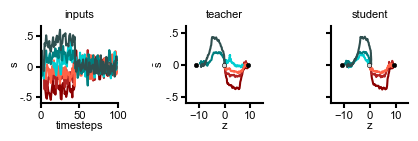

In [6]:
# make plot

with mpl.rc_context(fname="matplotlibrc"):

    colors = [
        "darkred",
        "firebrick",
        "tomato",
        "darkturquoise",
        "teal",
        "darkslategrey",
    ]
    fig, ax = plt.subplots(1, 3, figsize=(5, 1))
    for i in range(6):
        ax[2].plot(Z[i, 0, :, 0].T, v[i, 0, :, 0].T, color=colors[i % 6])
        latent_code = task.latents[i]
        task_v = task.v[i]
        ax[1].plot(latent_code[0], task_v[0], color=colors[i % 6])
        ax[0].plot(task.stim[i, 0], color=colors[i % 6])
    ax[1].set_xlabel(r"$z$")
    ax[1].set_ylabel(r"$\tilde{s}$")
    ax[0].set_ylabel(r"$s$")
    ax[0].set_xlabel("timesteps")
    ax[2].set_xlabel(r"$z$")
    ax[1].set_title("teacher")
    ax[2].set_title("student")
    # marker style
    dot_s = 10
    dot_z = 100
    dot_ew = 0.4
    dot_s_st = 20
    dot_fill = "gainsboro"

    # Calculate stability of fixed points and plots
    for z in z_list:
        e, vec = np.linalg.eig(PL_Jacobian(pV, pU, -pB, np.diag(np.ones(1) * tau), z))
        if e[0] > 1:
            ax[2].scatter(
                z[0],
                0,
                s=dot_s,
                c=dot_fill,
                edgecolor="black",
                lw=dot_ew,
                marker=MarkerStyle("o"),
                zorder=dot_z,
            )
        else:
            ax[2].scatter(
                z[0],
                0,
                s=dot_s,
                c="black",
                edgecolor="black",
                lw=dot_ew,
                marker=MarkerStyle("o"),
                zorder=dot_z,
            )

    for z in z_listGT:
        e, vec = np.linalg.eig(
            PL_Jacobian(V.numpy(), U.numpy(), B.numpy(), np.diag(np.ones(1) * 0.9), z)
        )
        if e[0] > 1:
            ax[1].scatter(
                z[0],
                0,
                s=dot_s,
                c=dot_fill,
                edgecolor="black",
                lw=dot_ew,
                marker=MarkerStyle("o"),
                zorder=dot_z,
            )
        else:
            ax[1].scatter(
                z[0],
                0,
                s=dot_s,
                c="black",
                edgecolor="black",
                lw=dot_ew,
                marker=MarkerStyle("o"),
                zorder=dot_z,
            )

    ax[1].set_xlim(-15, 15)
    ax[1].set_ylim(-0.6, 0.6)
    ax[2].set_xlim(-15, 15)
    ax[2].set_ylim(-0.6, 0.6)
    ax[2].set_ylim(-0.6, 0.6)
    ax[0].set_box_aspect(1)
    ax[1].set_box_aspect(1)
    ax[2].set_box_aspect(1)
    ax[2].set_yticklabels([])
    ax[0].set_yticks([-0.5, 0, 0.5])
    plt.subplots_adjust(wspace=0.5)

    ax[0].set_yticklabels(["-.5", "0", ".5"])
    ax[1].set_yticks([-0.5, 0, 0.5])
    ax[1].set_yticklabels(["-.5", "0", ".5"])
    ax[0].set_xlim(0, 100)
    ax[0].set_title("inputs")
    plt.savefig("../figures/inputs.pdf")
    plt.savefig("../figures/inputs.png")